In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils
import events_utils.data_loader as data_loader

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 6.0
duration = 0.8
t_end = t_start + duration
shape = (128, 128)
dataset = "data/scn1_take01/"
sub_factor=1

In [4]:
events_raw, depths, rgbs = data_loader.load_scn(path + dataset)

In [5]:
events_conv, new_shape = flt.filter_conv(events_raw, shape, factor=sub_factor)
shape = new_shape

In [6]:
events = flt.filter_refract(events_conv, 0.5)

In [7]:
events = flt.filter_time(events, t_start, t_end)

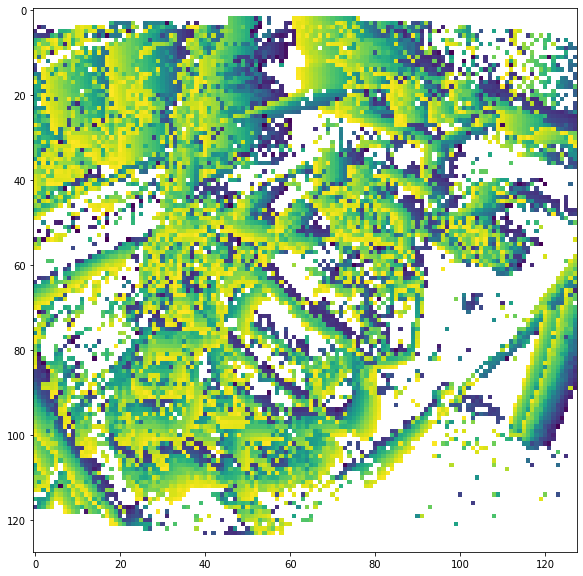

In [8]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [9]:
U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=7, std_thr=10.1, mean_thr=0.05, start_delay=0.00, final_delay=0.00)

100%|█████████████████████████████████████████████████████████████████████████| 20746/20746 [00:01<00:00, 16654.55it/s]


In [10]:
# U, V = td2d.measure_td_raw(events, shape, dist=1)

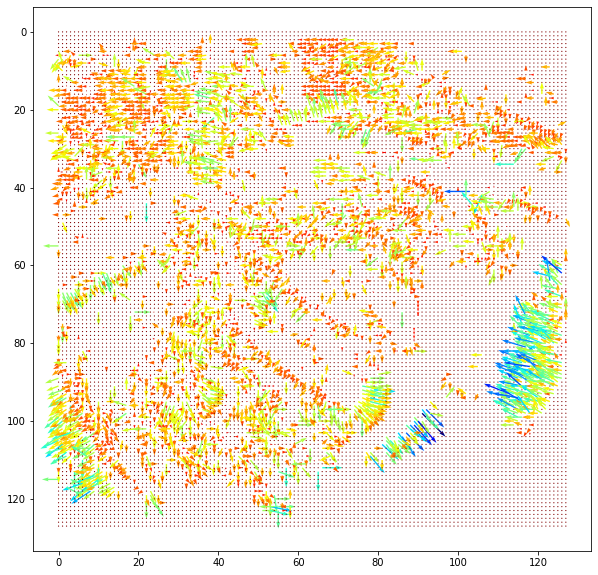

In [11]:
m = np.sqrt(U**2 + V**2)
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

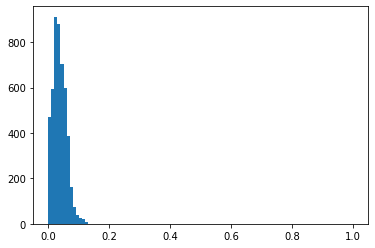

In [12]:
plt.hist(m.flatten(), 100, range=(0.0001, 1));

374


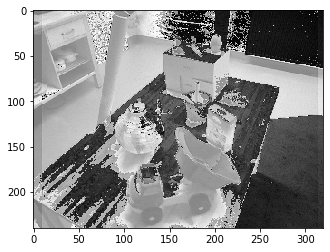

In [54]:
idx = np.floor((rgbs.shape[0] * t_start) / 30).astype(int)
print(idx)
plt.imshow(rgbs[idx+100], interpolation="none", cmap="gray")

In [22]:
pos = np.loadtxt(path + dataset + "gt_pos.csv", delimiter=",", skiprows=1)

In [23]:
idx = np.searchsorted(pos[:, 0], t_start)
pose1 = pos[idx]
pose2 = pos[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = (t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[  9.73621 160.99759 -64.3429 ]
[  9.95274 161.06575 -64.28777]
[0.21653 0.06816 0.05513]
0.009999999999999787


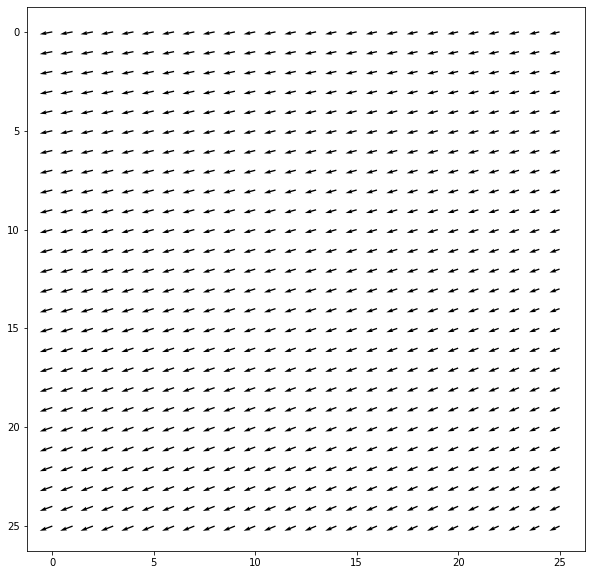

In [24]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, 150, [64, 64], (128, 128))
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 5
plt.quiver(t_U[::a, ::a], t_V[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

In [41]:
pos = np.loadtxt(path + dataset + "gt_rot.csv", delimiter=",", skiprows=1)
idx = np.searchsorted(pos[:, 0], t_start)
pose1 = pos[idx]
pose2 = pos[idx + 1]

a1 = pose1[1:4]
a2 = pose2[1:4]

print(a1)
print(a2)

a_vel = (a2 - a1) #/ (pose2[0] - pose1[0])

print(a_vel)
print(pose2[0] - pose1[0])

[-22.67582  21.90929 -49.99851]
[-22.82522  21.94233 -49.99586]
[-0.1494   0.03304  0.00265]
0.009999999999999787


In [42]:
ang_U, ang_V = flow_utils.get_angular_flow(a_vel, 150, [64, 64], (128, 128))

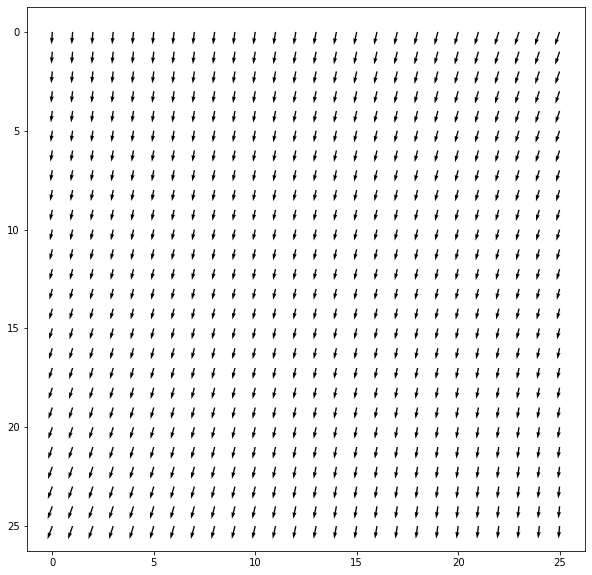

In [43]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 5
plt.quiver(ang_U[::a, ::a], ang_V[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

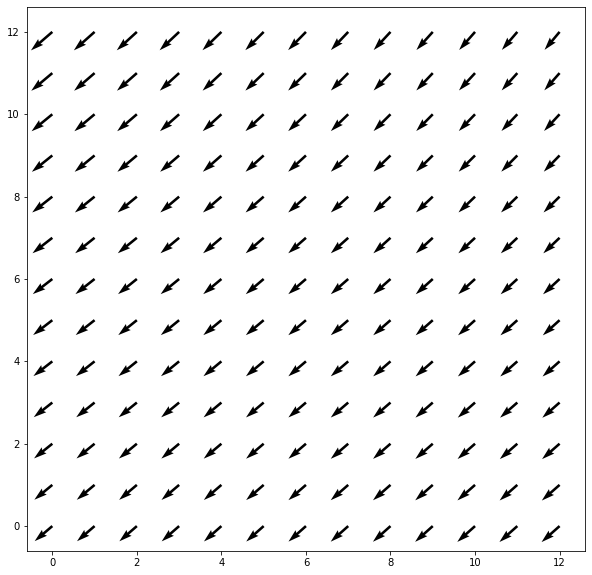

In [44]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [45]:
test, test_u, test_v = td2d.extract_depth2((128, 128), U, V, t_U, t_V)

0.9250206004263807


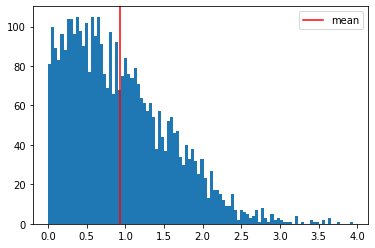

In [46]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);
plt.axvline(x=np.ma.mean(test_m), c="red", label="mean")
print(np.ma.mean(test_m))
plt.legend()

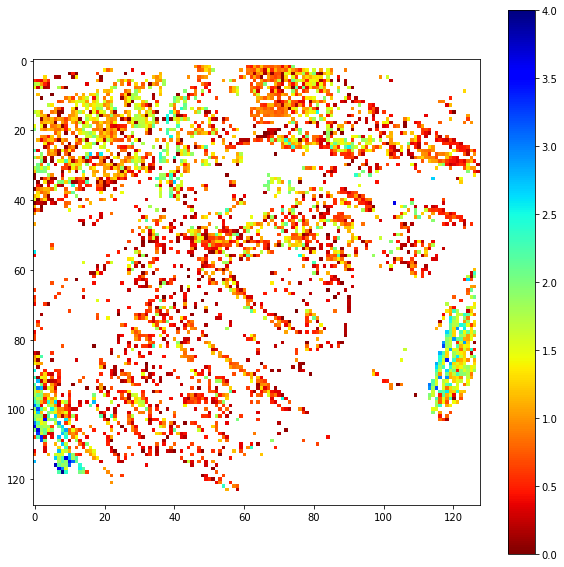

In [47]:
plt.figure(figsize=(10, 10))
m = plt.imshow(test_m, interpolation="none", cmap="jet_r", vmin=0, vmax=4)
plt.colorbar(m)

In [49]:
(1871 * t_start) / 30

374.2

In [50]:
def depths2img(depths, shape):
    img = np.zeros(shape)

    for e in depths:
        x = int(e[1])
        y = int(e[2])

        img[y, x] = e[3]
        
    return img

In [51]:
depths_t =  flt.filter_time(depths, t_start, t_end)

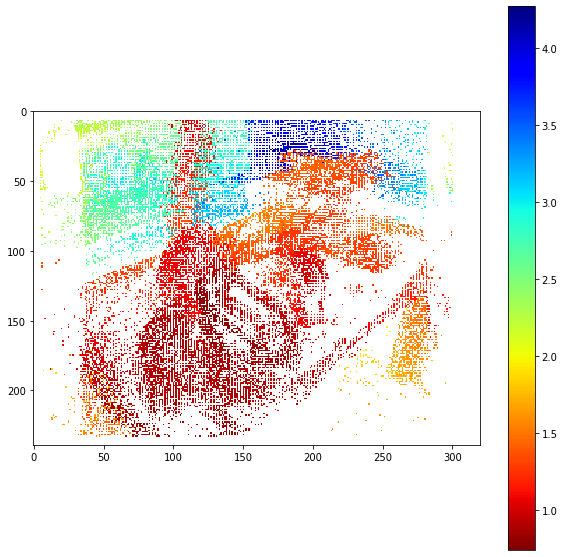

In [52]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = depths2img(depths_t, (240, 320)) * 1e-3
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none", cmap="jet_r")
plt.colorbar(mappable=m)

In [534]:
depths_t[0]

array([   6.000175,  196.      ,   97.      , 1239.      ])